In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("cnn_workflow")
import cnn_workflow
from utils import *
from Results import Result

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.models
import numpy as np
import torch.optim as optim
from tqdm.notebook import tqdm
from tabulate import tabulate
from easydict import EasyDict as edict

%matplotlib inline
import matplotlib.pyplot as  plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [16, 4]

In [3]:
def show_images_row(images, title="", axtitles=None):
    fig, axs = plt.subplots(nrows=1, ncols=len(images), figsize=(4*len(images),4))
    axs = axs if isinstance(axs, np.ndarray) else [axs]

    y_offset = 0 if axtitles== None else axtitles[0].count('\n')*0.03 + title.count('\n')*0.05

    fig.suptitle(title, x=0.5, y=0.98 + y_offset)
    for idx, (ax, image) in enumerate(zip(axs,images)):
        im = np.transpose(image, (1,2,0))
        ax.imshow(im)
        if axtitles:
            ax.set_title(axtitles[idx],loc='left', fontsize='smaller')
        ax.axis('off')

In [4]:
def mean_std(loader):
    """
    calculate mean and std for each channel across all batches and pixels
    """
    n_data = len(loader.dataset)
    num_pixels = loader.dataset[0][0].shape[1]*loader.dataset[0][0].shape[2]*n_data

    sum = torch.zeros(3)
    for data, _ in loader:
        sum+=data.sum(dim=[0,2,3])
    mean = sum/num_pixels

    sum_of_squared_error = torch.zeros(3)
    for data, _ in loader: 
        sum_of_squared_error += ((data - mean.reshape(3,1,1))**2).sum(dim=[0,2,3])
    std = torch.sqrt(sum_of_squared_error / num_pixels)

    return mean, std


def denormalize_images(images, mean, std):
    if isinstance(images,list):
        return [img*std.reshape([3,1,1]).numpy() + mean.reshape([3,1,1]).numpy() for img in images]
    if isinstance(images,torch.Tensor):
        return images*std.reshape([3,1,1]) + mean.reshape([3,1,1])

def shitfndivide(data):
    """
        output data will be in interval [0..1] per channel for each image in batch
    """
    b = data.shape[0]

    mins = data.min(dim=2)[0].min(dim=2)[0]
    data2 = data - mins.reshape([b,3,1,1])

    maxs = data2.max(dim=2)[0].max(dim=2)[0]
    data3 = data2/maxs.reshape([b,3,1,1])

    return data3


(0): Linear(in_features=25088, out_features=4096, bias=True)

(1): ReLU(inplace=True)

(2): Dropout(p=0.5, inplace=False)

(3): Linear(in_features=4096, out_features=4096, bias=True)

(4): ReLU(inplace=True)

(5): Dropout(p=0.5, inplace=False)

(6): Linear(in_features=4096, out_features=1000, bias=True)


In [5]:
def get_vgg(vgg: str, freeze_features = True):
    """
        Function to load vgg from torchvision.models module.
        @param vgg can be:  vgg11, vgg11_bn, vgg13, vgg13_bn, vgg16, vgg16_bn, vgg19_bn, vgg19 .... see torchvision/models/vgg.py
    """
    vgg_fn = getattr(torchvision.models, vgg)
    model = vgg_fn(pretrained=True)
    add_note(model, vgg)
    if freeze_features:
        for param in model.parameters():
            param.requires_grad = False

    in_features = model.classifier[0].in_features

    # model.classifier= nn.Sequential(
    #     nn.Linear(in_features = in_features, out_features=4096),
    #     nn.ReLU(),
    #     nn.Dropout(0.5),
    #     nn.Linear(4096,num_classes)
    # )

    add_note(model, 'classifier 2')
    model.classifier= nn.Sequential(
        nn.Linear(in_features = in_features, out_features=4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(in_features = 4096, out_features=4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, num_classes)
    )
    

    return model

In [6]:
def get_misclassified(model, device, test_loader):
    """
    get target class, confidences and data of misclassified data
    """
    model.eval()

    confidence_list = []
    target_list = []
    data_list = []

    with torch.no_grad():
        for b_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            probs = F.softmax(output, dim=1)
            confidence, predicted = torch.max(probs, dim=1)
            wrong_idx = torch.where(predicted != target)

            if len(wrong_idx) == 0 :
                continue

            confidence_list.append(probs[wrong_idx])
            target_list.append(target[wrong_idx])
            data_list.append(data[wrong_idx])

    return torch.concat(target_list), torch.concat(confidence_list), torch.concat(data_list)

def get_top_confidences(confidences, top=3):
    """
    return list of tuples (classes, confidence), data in each tuple is sorted by confidence
    """
    sorted, sort_idx = torch.sort(confidences, descending=True)
    return [(target[:top], confidence[:top]) for target, confidence in zip(sort_idx, sorted)]

def get_target_confidence(confidences, targets):
    tc = confidences.gather(1,targets[None,...].T)
    return tc.squeeze(1)

In [7]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# Part 1

Create dataset and a loader for training and test images

In [8]:
num_classes = 10
batch_size  = 32
num_workers = 5

train_data = datasets.ImageFolder('data/butterflies/train', transforms.ToTensor())
test_data = datasets.ImageFolder('data/butterflies/test', transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# show_images_row([train_data[i][0] for i in range(10)], [str(train_data[i][1]) for i in range(10)])

Perform standartization of the train and test data: compute mean and standard deviation per color channel over all pixels and all images in the training and test sets.

In [9]:
train_mean, train_std = mean_std(train_loader)
print(f'train data mean per channel: {train_mean}')
print(f'train data std per channel: {train_std}')
train_data_normalized = datasets.ImageFolder('data/butterflies/train', transform=transforms.Compose([ transforms.ToTensor() , transforms.Normalize(train_mean, train_std)]))

test_mean, test_std = mean_std(test_loader)
print(f'test data mean per channel: {test_mean}')
print(f'test data std per channel: {test_std}')
test_data_normalized = datasets.ImageFolder('data/butterflies/test', transform=transforms.Compose([ transforms.ToTensor() , transforms.Normalize(test_mean, test_std)]))

train data mean per channel: tensor([0.4631, 0.4483, 0.3237])
train data std per channel: tensor([0.2828, 0.2648, 0.2752])
test data mean per channel: tensor([0.4548, 0.4413, 0.3095])
test data std per channel: tensor([0.2846, 0.2691, 0.2695])


Split the normalized training data into train and validation subsets with fraction of validation data `val_fraction`.  Create loaders for train, validation and test  normalized data.

In [10]:
val_fraction=0.2
split_index = int(val_fraction*len(train_data))
val_indices, train_indices = torch.randperm(len(train_data)).tensor_split([split_index])

#TODO: try WeightedRandomSampler  https://towardsdatascience.com/pytorch-basics-sampling-samplers-2a0f29f0bf2a
train_loader_normalized = torch.utils.data.DataLoader(train_data_normalized, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_indices), num_workers = num_workers, pin_memory=True)
val_loader_normalized = torch.utils.data.DataLoader(train_data_normalized, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(val_indices), num_workers = num_workers, pin_memory=True)
test_loader_normalized = torch.utils.data.DataLoader(test_data_normalized, batch_size=batch_size, num_workers = num_workers, pin_memory=True)

data_loader = edict({'train_loader': train_loader_normalized, 'val_loader':val_loader_normalized, 'test_loader': test_loader_normalized})
print(f"#train samples: {len(train_data) - split_index}")
print(f"#validation samples: {split_index}")
print(f"#test samples: {len(test_data)}")

#train samples: 546
#validation samples: 136
#test samples: 150


In [11]:
def test_bs_nw(td, device):
    from time import time
    bs_times = {}
    for bs in tqdm([4,8,16,32,64]):
        times = {}
        for nw in range(1,20):

            train_loader_normalized = torch.utils.data.DataLoader(td, batch_size=bs, sampler=torch.utils.data.SubsetRandomSampler(train_indices), num_workers = nw, pin_memory=True)
            val_loader_normalized = torch.utils.data.DataLoader(td, batch_size=bs, sampler=torch.utils.data.SubsetRandomSampler(val_indices),num_workers = nw, pin_memory=True) # pinned memory 
            data_loader2 = edict({'train_loader': train_loader_normalized, 'val_loader':val_loader_normalized})

            model  = get_vgg('vgg11', True).to(device)
            opt = optim.Adadelta(model.parameters(), lr=0.1)
            t1 = time()
            cnn_workflow.train(model, device, data_loader2, opt, epoch_num=1, save_epochs=False, loss_fn=F.cross_entropy, disable_tqdm=True)
            t2 = time()
            times[nw] = t2-t1
        bs_times[bs] = times


def plot_nw_test(data):
    for k in data:
        xs = list(data[k].keys())
        ys = list(data[k].values())
        plt.plot(xs,ys)
        plt.xticks(xs)
    plt.legend(list(data.keys()))

# data = test_bs_nw(train_data_normalized, device)
# plot_nw_test(data)

# Part 2 

Using the above defined function `get_vgg` load vgg11 model, freeze all parameters, redefine its classifier.

Train the network with learning rates 0.1, 0.01, 0.001, 0.0001

In [12]:
def lr_test(device, data_loader, epoch_num, lrs, vgg, freeze_features, note):
    results = []
    for lr in lrs:
        model  = get_vgg(vgg, freeze_features).to(device)
        add_note(model, note)
        opt = optim.Adadelta(model.parameters(), lr=lr)
        # lambda1 = lambda epoch: 0.67 ** epoch
        # scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)
        scheduler = None
        r = cnn_workflow.train(model, device, data_loader, opt, epoch_num=epoch_num, save_epochs=True, loss_fn=F.cross_entropy, scheduler=scheduler)

        results.append(r)

    return results


vgg = 'vgg11'
lrs = [.1, .01, .001, .0001]
results_fe = lr_test(device, data_loader, epoch_num=5, lrs=lrs, vgg=vgg, freeze_features=True, note='feature extraction')

Created dir: runs/2022_04_26 13_53_48 VGG vgg11 classifier 2 feature extraction e=5 lr=0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Created dir: runs/2022_04_26 13_54_20 VGG vgg11 classifier 2 feature extraction e=5 lr=0.01


  0%|          | 0/5 [00:00<?, ?it/s]

Created dir: runs/2022_04_26 13_54_51 VGG vgg11 classifier 2 feature extraction e=5 lr=0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Created dir: runs/2022_04_26 13_55_22 VGG vgg11 classifier 2 feature extraction e=5 lr=0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

selected lr 0.1 with training loss 0.00333 at epoch 5


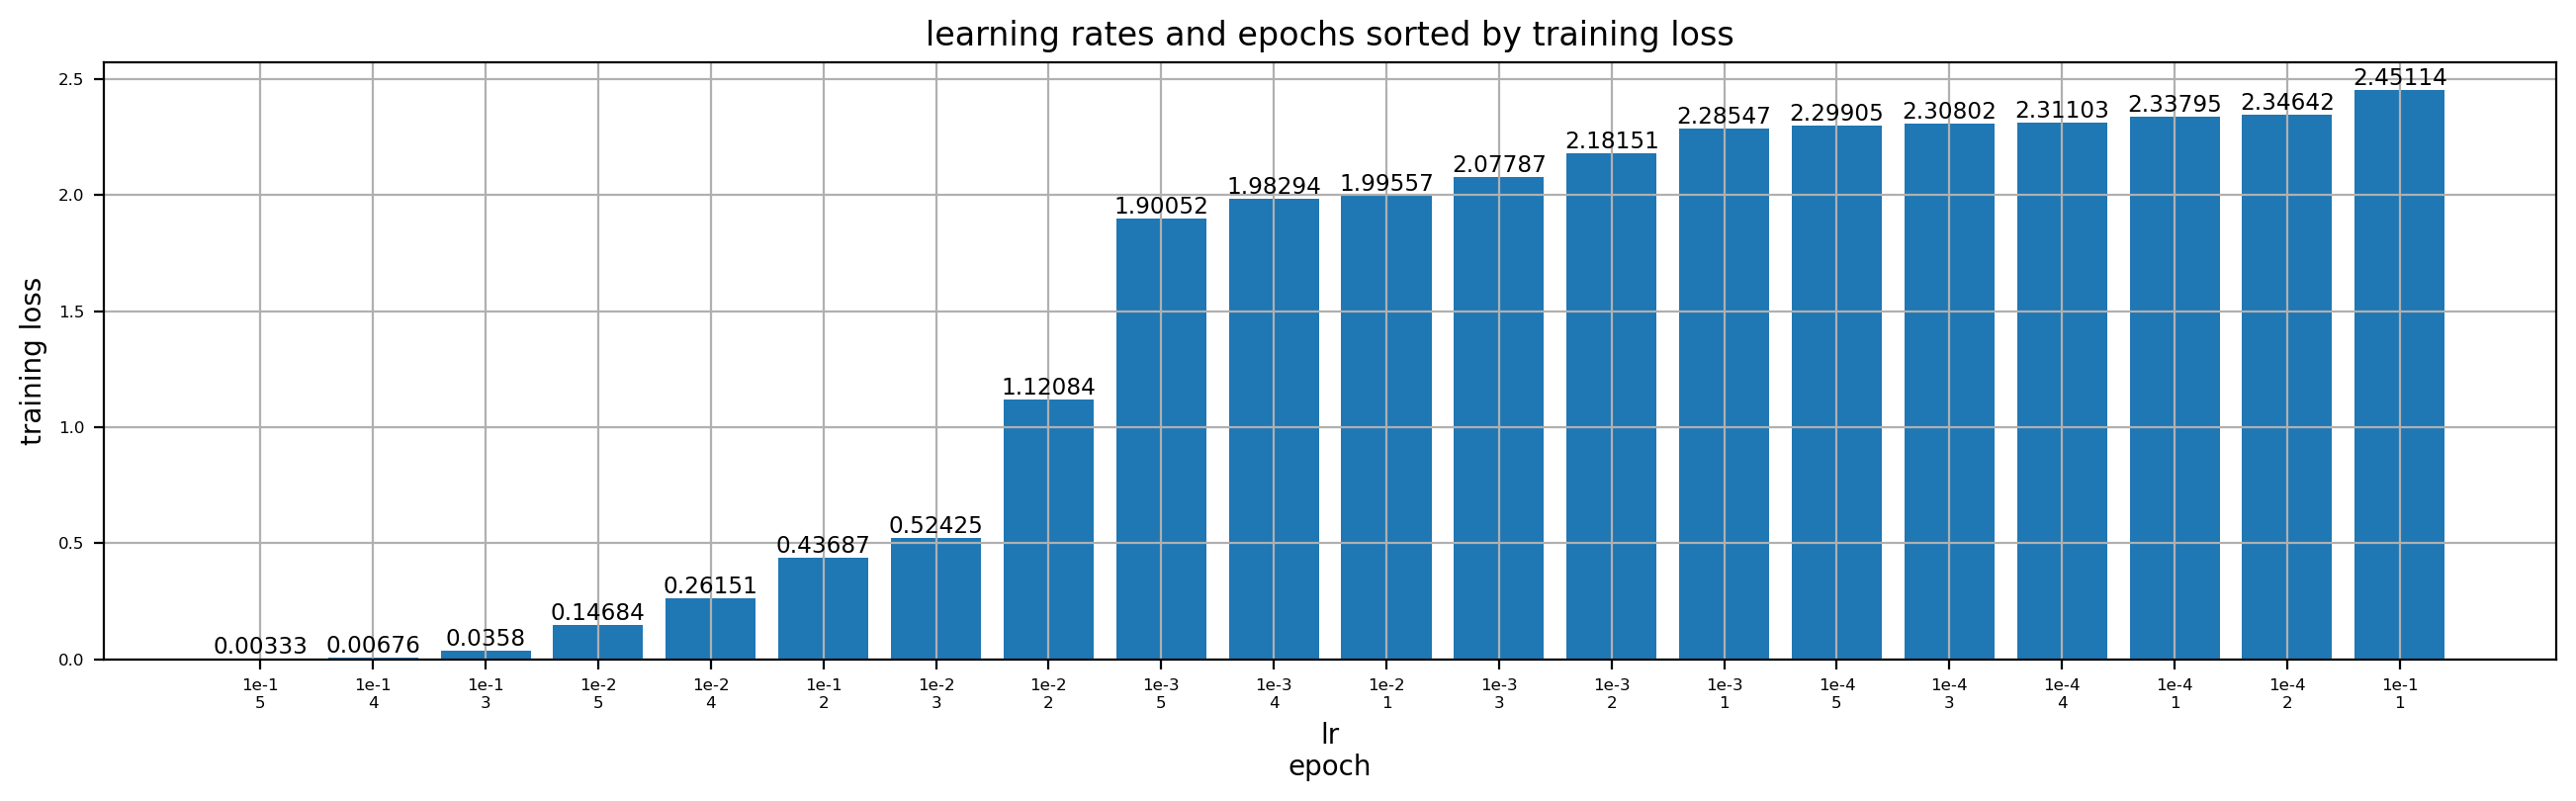

In [13]:
def select_best_lr(results, lrs, based_on, descending, plot=True):
    lr_epoch_param = [(lr, e, p) for result, lr in zip(results, lrs) for e, p in result[based_on].items()]

    lr_epoch_param.sort(key=lambda tup: tup[2], reverse = descending)
    best_lr, best_epoch, best_param = lr_epoch_param[0]

    print(f'selected lr {best_lr} with {Result.pstr(based_on)} {best_param:.5f} at epoch {best_epoch}')

    plot and plor_bars(Result.pstr(based_on), lr_epoch_param)

    return best_lr

def plor_bars(param_name, lr_epoch_param):
    fig, ax = plt.subplots()
    ax.set_title(f'learning rates and epochs sorted by {param_name}')
    ax.set_ylabel(param_name)
    ax.set_xlabel('lr\nepoch')
    format_lr_epoch = lambda x: f'{np.format_float_scientific(x[0], precision = 1, exp_digits=1,trim="-")}\n{x[1]}'
    bars = ax.bar(list(map(format_lr_epoch, lr_epoch_param)), list(map(lambda x: x[2], lr_epoch_param)))
    ax.tick_params(axis='both', which='major', labelsize=6)
    bar_labels = [ ('%.5f' % v).rstrip('0').rstrip('.') for l,e,v in lr_epoch_param]
    ax.bar_label(bars,bar_labels, fontsize='small')
    plt.grid()


best_lr = select_best_lr(results_fe, lrs, based_on = 'trn_loss', descending = False)

In [14]:
def lrs_near_given(lr):
    return [ round(lr*c, 10) for c in  [5, 2, 1, 0.75, 0.5]]

lrs2 = lrs_near_given(best_lr)
results_fe2 = lr_test(device, data_loader, epoch_num=20, lrs=lrs2, vgg=vgg, freeze_features=True, note='feature extraction phase 2')

Created dir: runs/2022_04_26 13_55_54 VGG vgg11 classifier 2 feature extraction phase 2 e=20 lr=0.5


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_26 13_57_53 VGG vgg11 classifier 2 feature extraction phase 2 e=20 lr=0.2


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_26 13_59_51 VGG vgg11 classifier 2 feature extraction phase 2 e=20 lr=0.1


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_26 14_01_52 VGG vgg11 classifier 2 feature extraction phase 2 e=20 lr=0.075


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_26 14_03_51 VGG vgg11 classifier 2 feature extraction phase 2 e=20 lr=0.05


  0%|          | 0/20 [00:00<?, ?it/s]

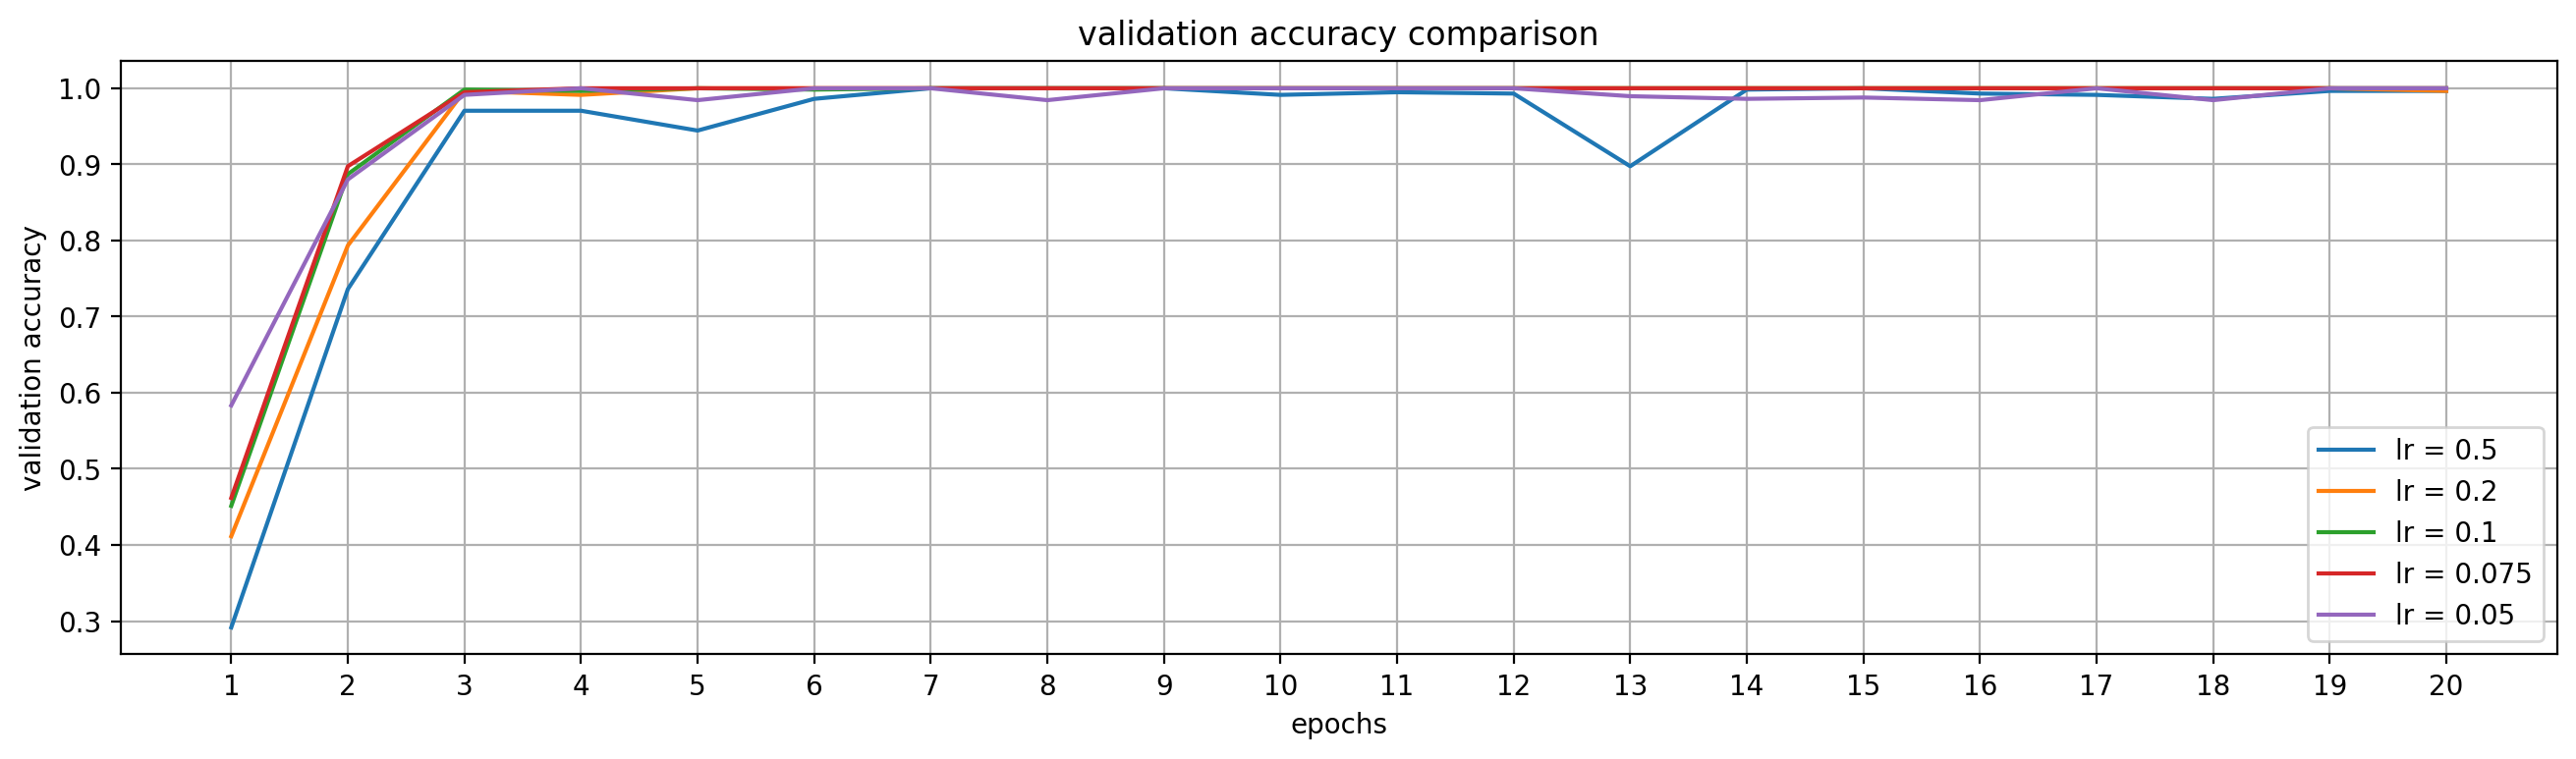

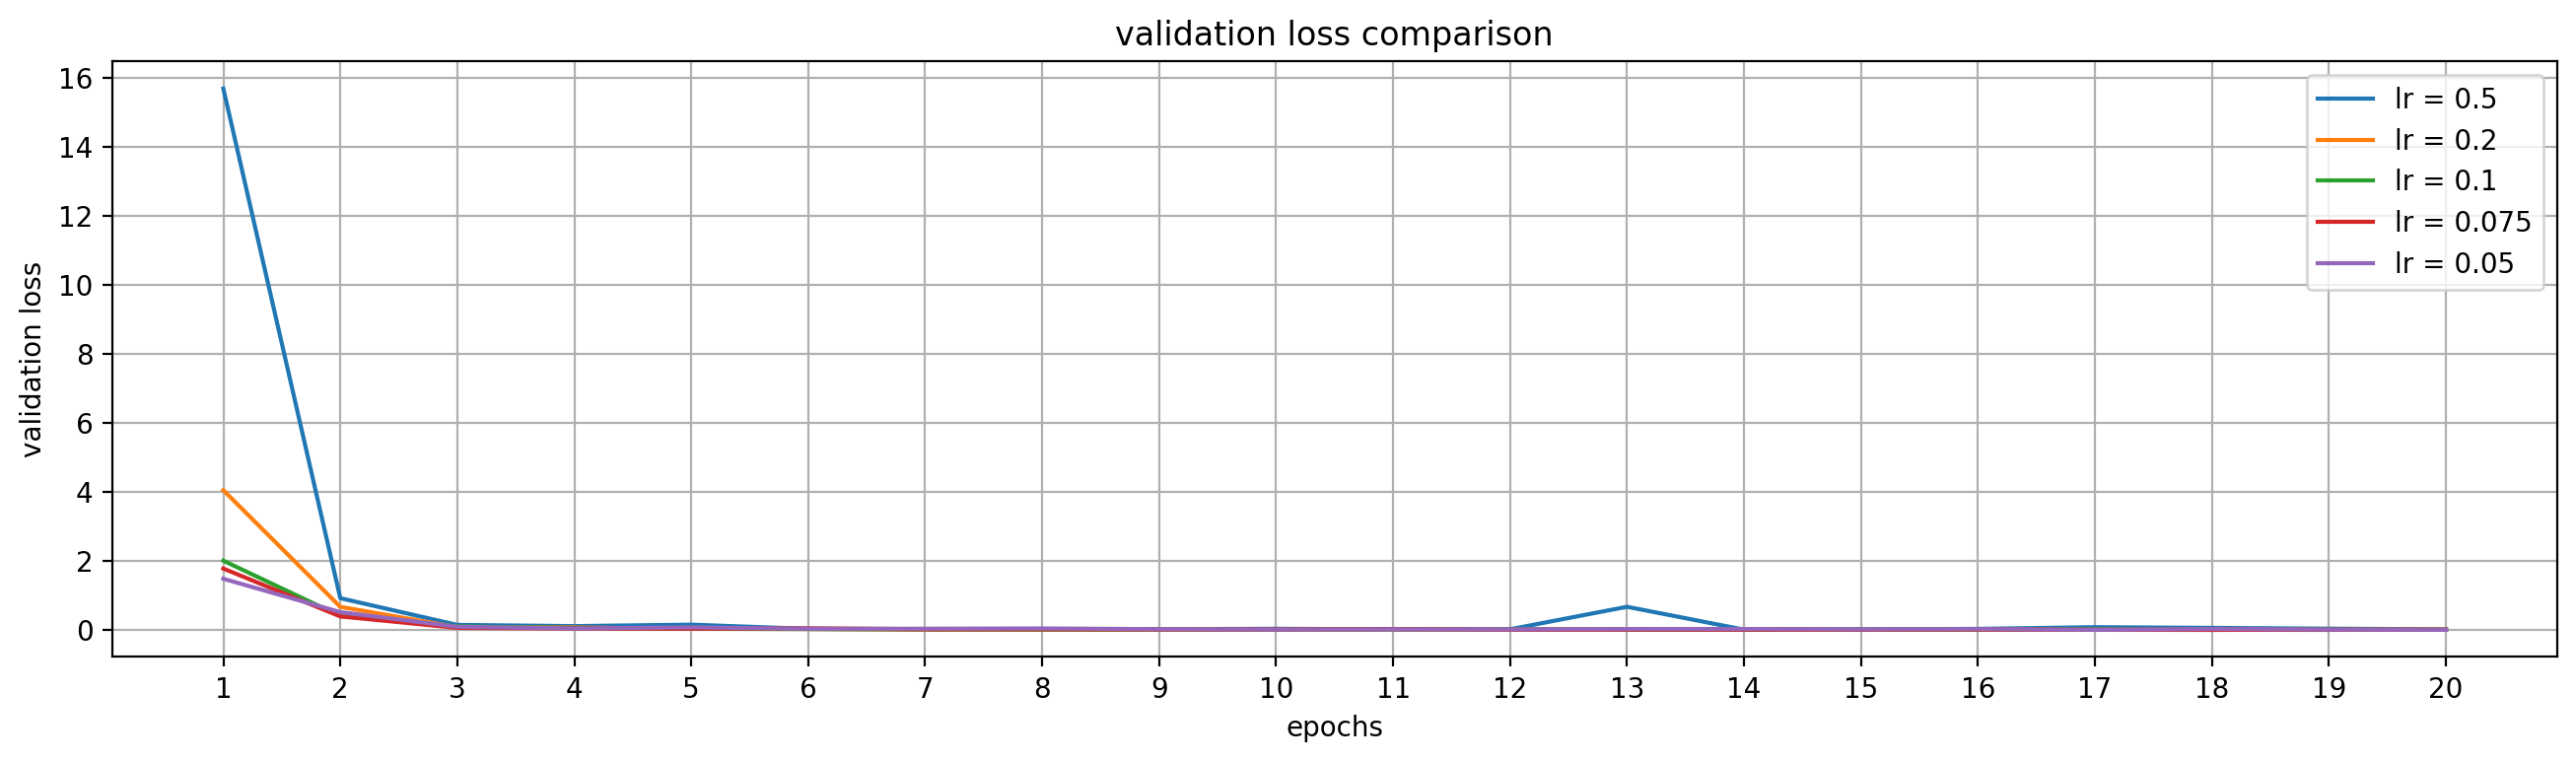

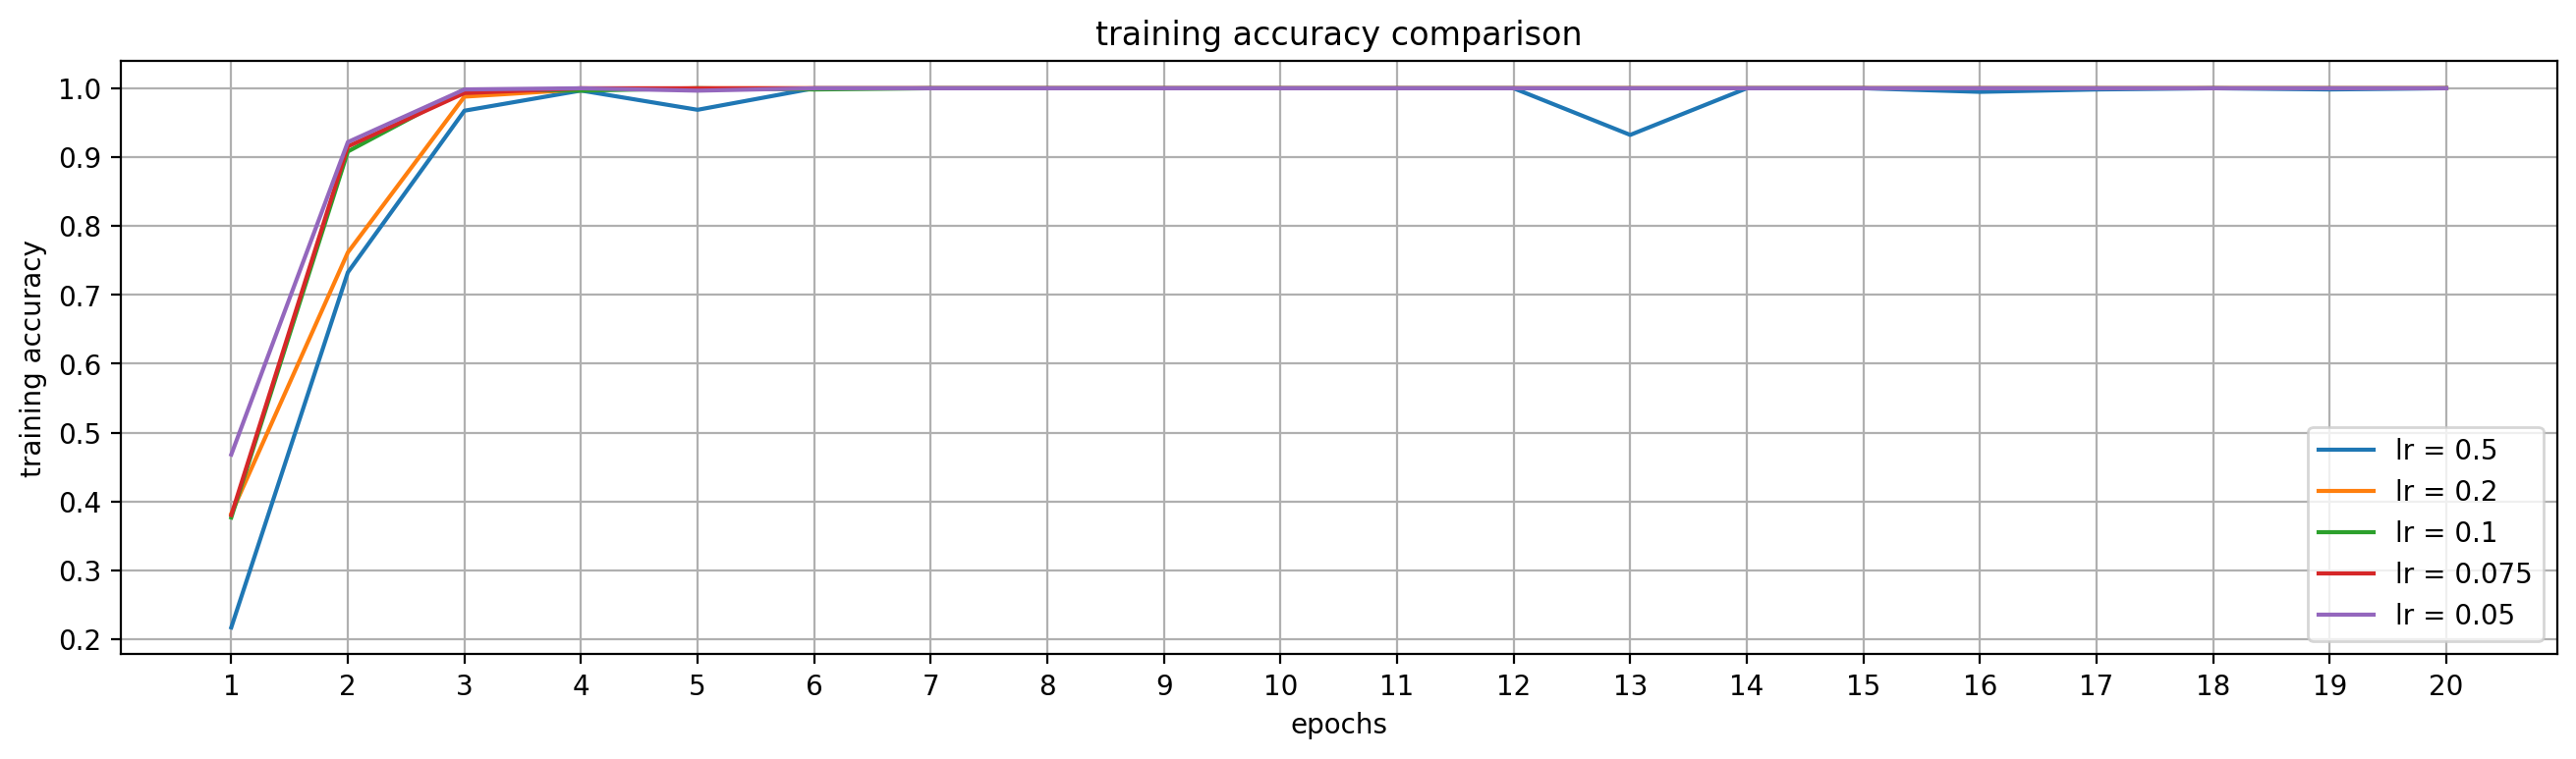

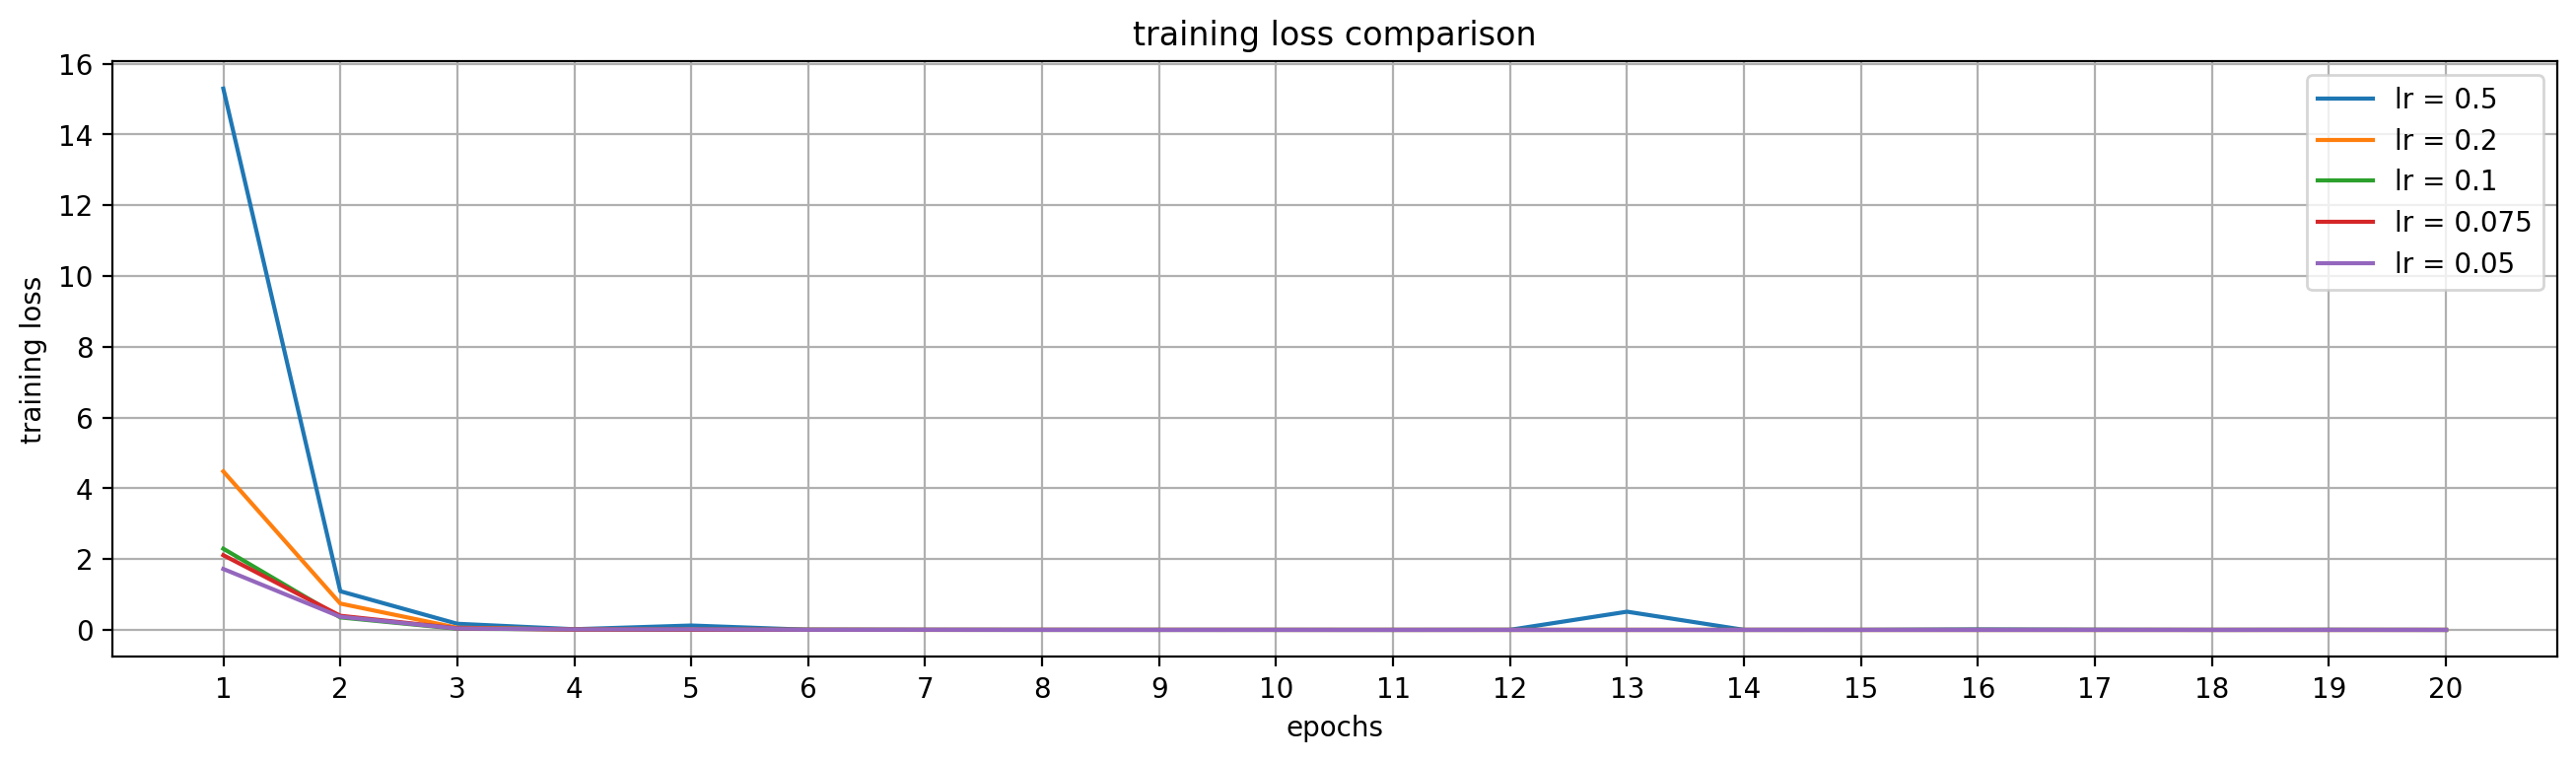

In [15]:
def lrs_to_str(lrs):
    return [f'{lr = }' for lr in lrs]

display_results_compare(results_fe2, lrs_to_str(lrs2))

selected lr 0.5 with validation accuracy 1.00000 at epoch 7


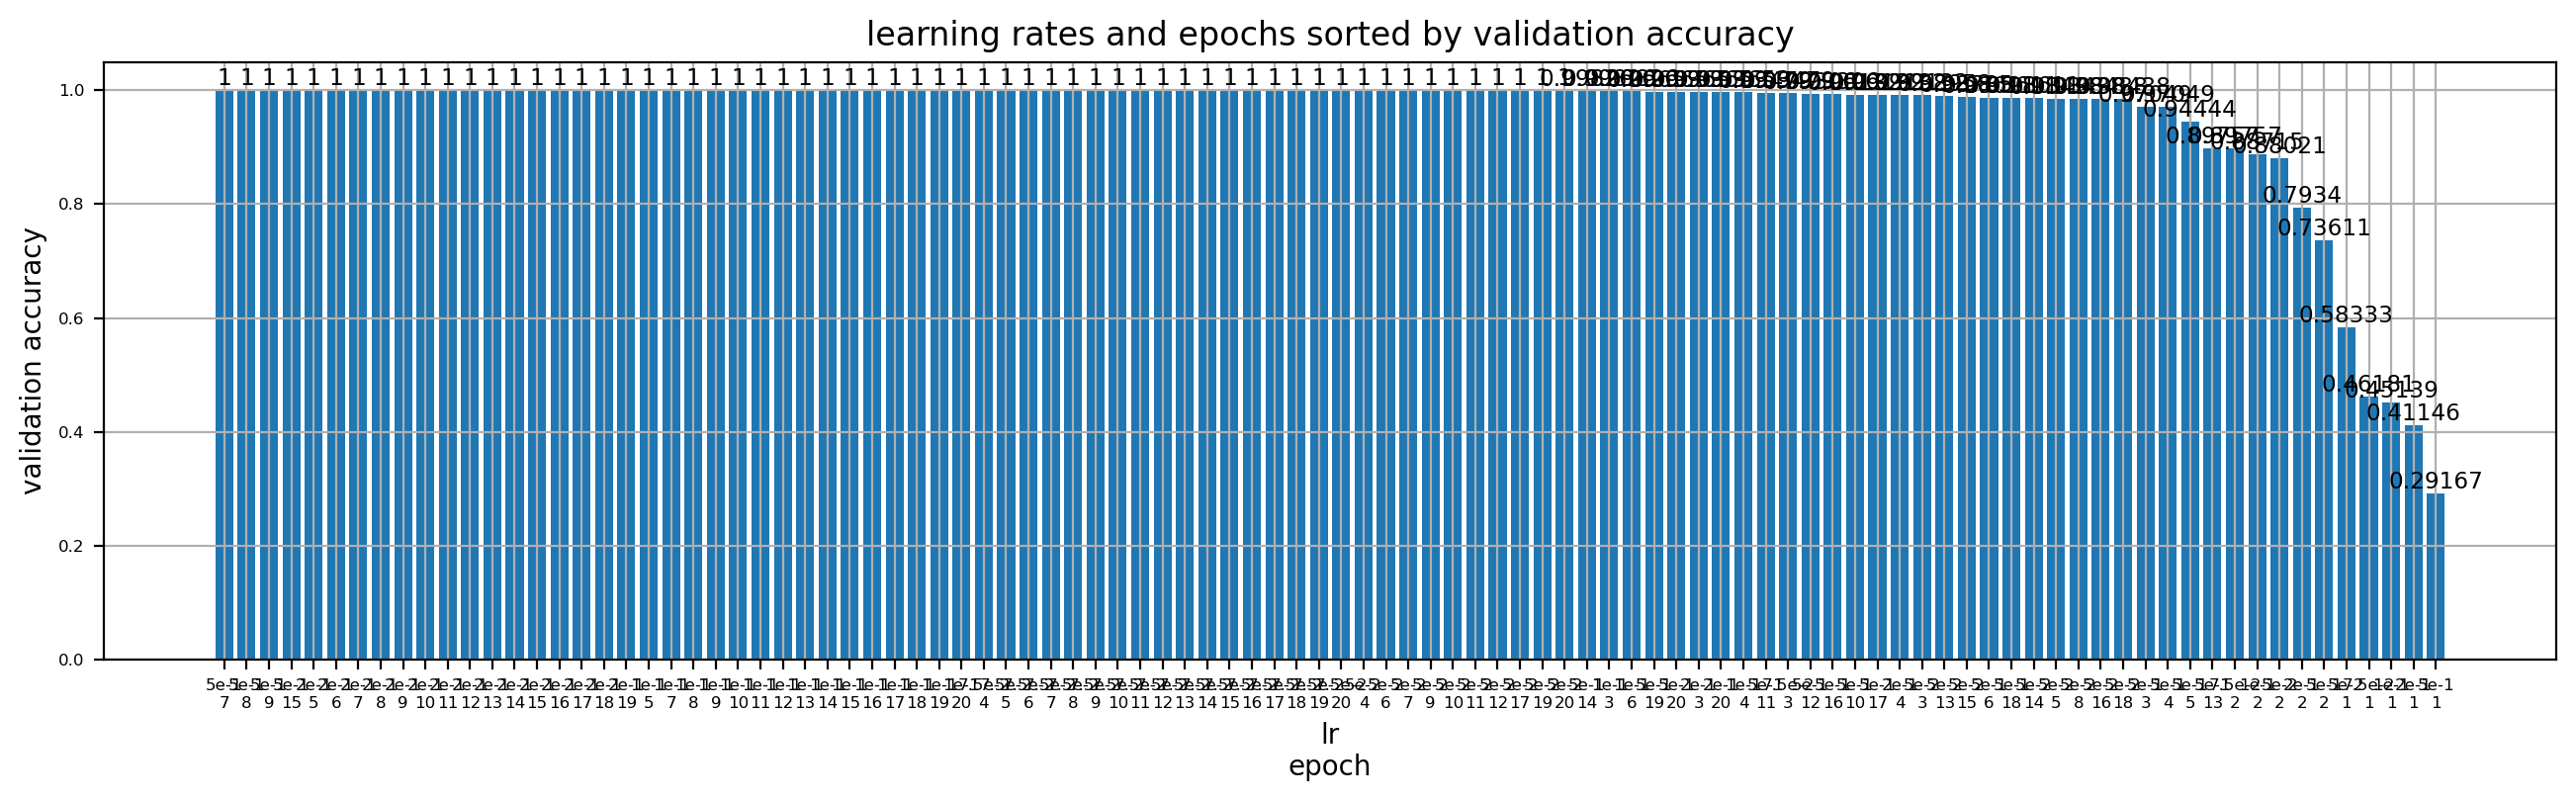

In [16]:
best_lr2 = select_best_lr(results_fe2, lrs2, based_on = 'val_acc', descending = True)

In [17]:
def get_test_results_sorted_by_vl(filter, data_loader, device):
    from utils import filter_subdirs, load_params_subdir, load_results_subdirs
    subdirs = filter_subdirs(filter)
    lrs = [load_params_subdir(sd).opt_lr for sd in subdirs]

    loaded_results_list = load_results_subdirs(subdirs)

    lr_epoch_result = [(lr, epoch, result) for results, lr in zip(loaded_results_list, lrs) for epoch, result in enumerate(results, start=1)]
    lr_epoch_result.sort(key=lambda x: x[2].val_acc, reverse=True) # sort by va
    lr_epoch_results_best_accuracy = [x for x in lr_epoch_result if x[2].val_acc==1.0]
    lr_epoch_results_best_accuracy.sort(key=lambda x: x[2].val_loss) # sort by vl
    print(f'{len(lr_epoch_results_best_accuracy)}/{len(lr_epoch_result)}')

    wfolder = []
    for lr, epoch, result in lr_epoch_results_best_accuracy:
        for df in subdirs:
            if f'lr={lr}' in df:
                wfolder.append((lr, epoch, result, df + f'/models/VGG_{epoch}.pt'))

    assert len(wfolder) == len(lr_epoch_results_best_accuracy)

    test_results = []
    for idx, (lr, epoch, result, state) in enumerate(tqdm(wfolder)):
        model = get_vgg('vgg11', True).to(device)
        cnn_workflow.load_state_to_network(device, state, model)
        tl, ta = cnn_workflow.evaluate(model, device, data_loader.test_loader, loss_fun=F.cross_entropy)
        test_results.append((idx,lr,epoch,result.val_loss,result.val_acc,tl,ta))

    return test_results


test_results = get_test_results_sorted_by_vl(['feature extraction phase 2'], data_loader, device)
print(tabulate(test_results, headers=['#','lr', 'epoch', "val loss", 'val acc',"test loss", "test acc"]))

61/100


  0%|          | 0/61 [00:00<?, ?it/s]

  #     lr    epoch    val loss    val acc    test loss    test acc
---  -----  -------  ----------  ---------  -----------  ----------
  0  0.2         19  0.00196666          1    0.067171     0.964015
  1  0.075       18  0.00260402          1    0.0542208    0.974432
  2  0.1         18  0.00296209          1    0.0503593    0.974432
  3  0.2         15  0.0037637           1    0.0709704    0.974432
  4  0.05        17  0.00413955          1    0.0508021    0.97964
  5  0.075       17  0.0041614           1    0.053954     0.974432
  6  0.2         18  0.00453716          1    0.0793512    0.964015
  7  0.2         14  0.00589256          1    0.073191     0.969223
  8  0.2         12  0.00590267          1    0.0683239    0.964015
  9  0.2         16  0.0061511           1    0.0842979    0.969223
 10  0.05        20  0.00631382          1    0.0494154    0.974432
 11  0.2         13  0.00663673          1    0.0799475    0.969223
 12  0.1         20  0.00664182          1    0.0

In [18]:
from utils import filter_subdirs
model_subdir = filter_subdirs([f'lr={test_results[0][1]}', 'feature extraction phase 2'])
assert len(model_subdir) == 1
model_state_file = model_subdir[0] + f'/models/VGG_{test_results[0][2]}.pt'

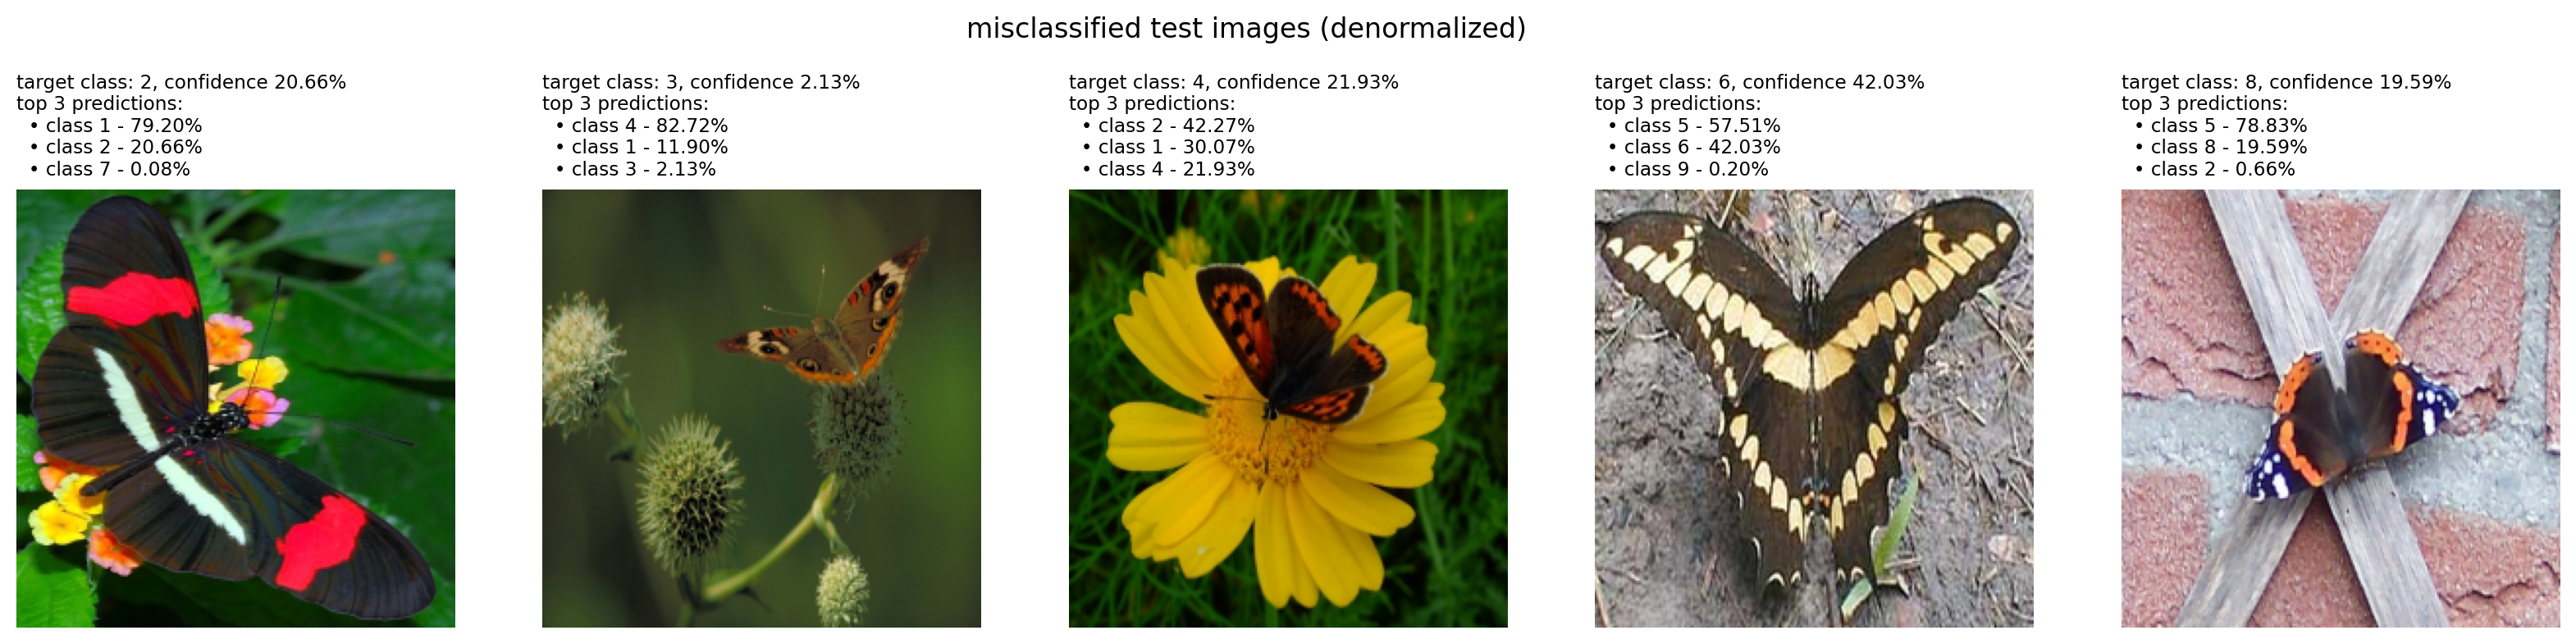

In [19]:
def show_misclassified(model, device, loader, mean, std):
    targets, confidences, data = get_misclassified(model, device, loader)
    top3_confidences = get_top_confidences(confidences)
    target_confidence = get_target_confidence(confidences, targets)

    top3strs = ["\n".join([f"  • class {target} - {confidence*100:.2f}%" for target, confidence in zip(*t3c)]) for t3c in top3_confidences]
    titles = [ f'target class: {t}, confidence {tc*100:.2f}%\ntop 3 predictions:\n{t3str}' for t, tc, t3str in zip(targets, target_confidence, top3strs)]

    denormalized_images = denormalize_images(data.cpu(), mean, std)

    # show_images_row(shitfndivide(data.cpu()), 'misclassified normalized test images\n(color intensity is shifted to be in [0,1] interval)', titles)
    show_images_row(denormalized_images, 'misclassified test images (denormalized)', titles)

model = get_vgg('vgg11').to(device)
cnn_workflow.load_state_to_network(device,model_state_file, model)
show_misclassified(model, device, data_loader.test_loader, test_mean, test_std)


# Part 3

Finetune the whole model.

In [20]:
lrs = [.1, .01, .001, .0001]
vgg = 'vgg11'
results_ft = lr_test(device, data_loader, epoch_num=5, lrs=lrs, vgg=vgg, freeze_features=False, note = 'finetuning')

Created dir: runs/2022_04_26 14_11_43 VGG vgg11 classifier 2 finetuning e=5 lr=0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Created dir: runs/2022_04_26 14_12_20 VGG vgg11 classifier 2 finetuning e=5 lr=0.01


  0%|          | 0/5 [00:00<?, ?it/s]

Created dir: runs/2022_04_26 14_12_59 VGG vgg11 classifier 2 finetuning e=5 lr=0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Created dir: runs/2022_04_26 14_13_38 VGG vgg11 classifier 2 finetuning e=5 lr=0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

selected lr 0.01 with training loss 0.01635 at epoch 5


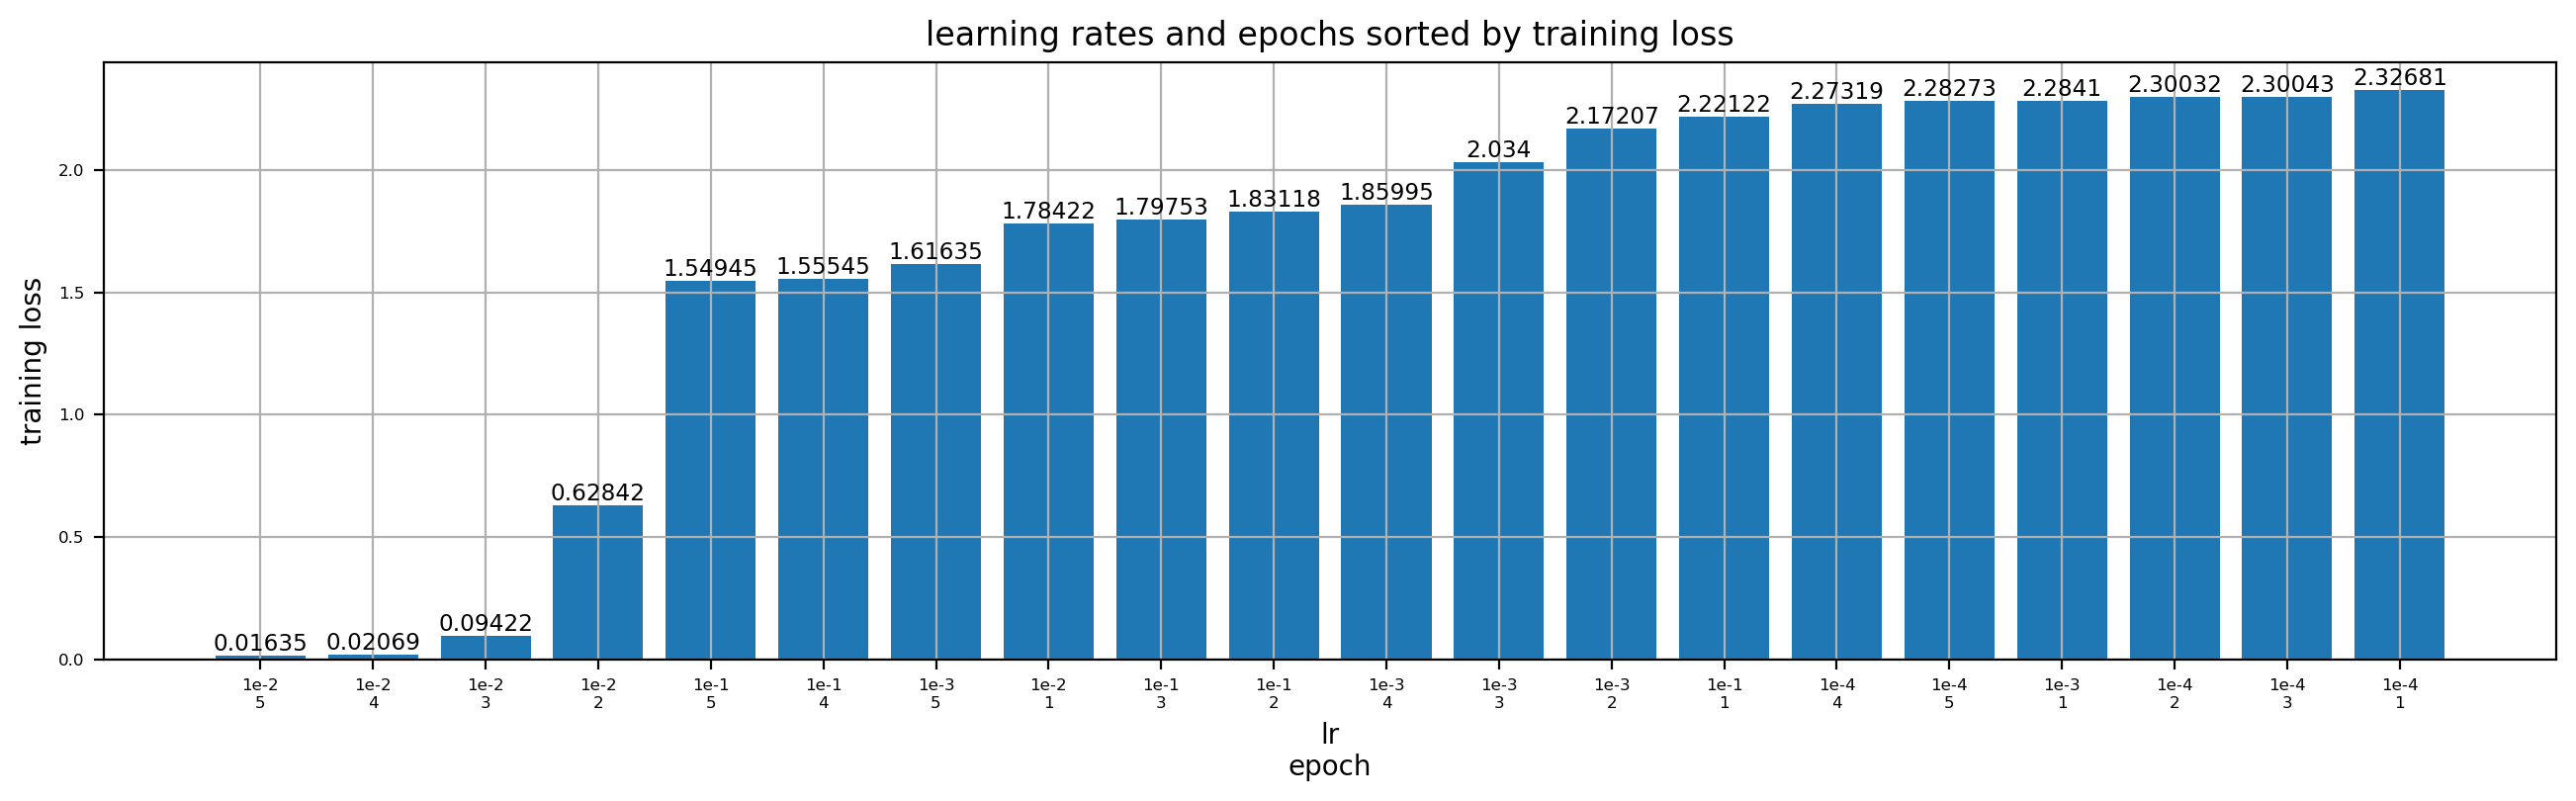

In [21]:
best_lr = select_best_lr(results_ft, lrs, based_on = 'trn_loss', descending = False)

In [22]:
lrs2 = lrs_near_given(best_lr)
results_ft2 = lr_test(device, data_loader, epoch_num=20, lrs=lrs2, vgg=vgg, freeze_features=False, note='finetuning phase 2')

Created dir: runs/2022_04_26 14_14_19 VGG vgg11 classifier 2 finetuning phase 2 e=20 lr=0.05


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_26 14_16_47 VGG vgg11 classifier 2 finetuning phase 2 e=20 lr=0.02


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_26 14_19_14 VGG vgg11 classifier 2 finetuning phase 2 e=20 lr=0.01


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_26 14_21_42 VGG vgg11 classifier 2 finetuning phase 2 e=20 lr=0.0075


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_26 14_24_10 VGG vgg11 classifier 2 finetuning phase 2 e=20 lr=0.005


  0%|          | 0/20 [00:00<?, ?it/s]

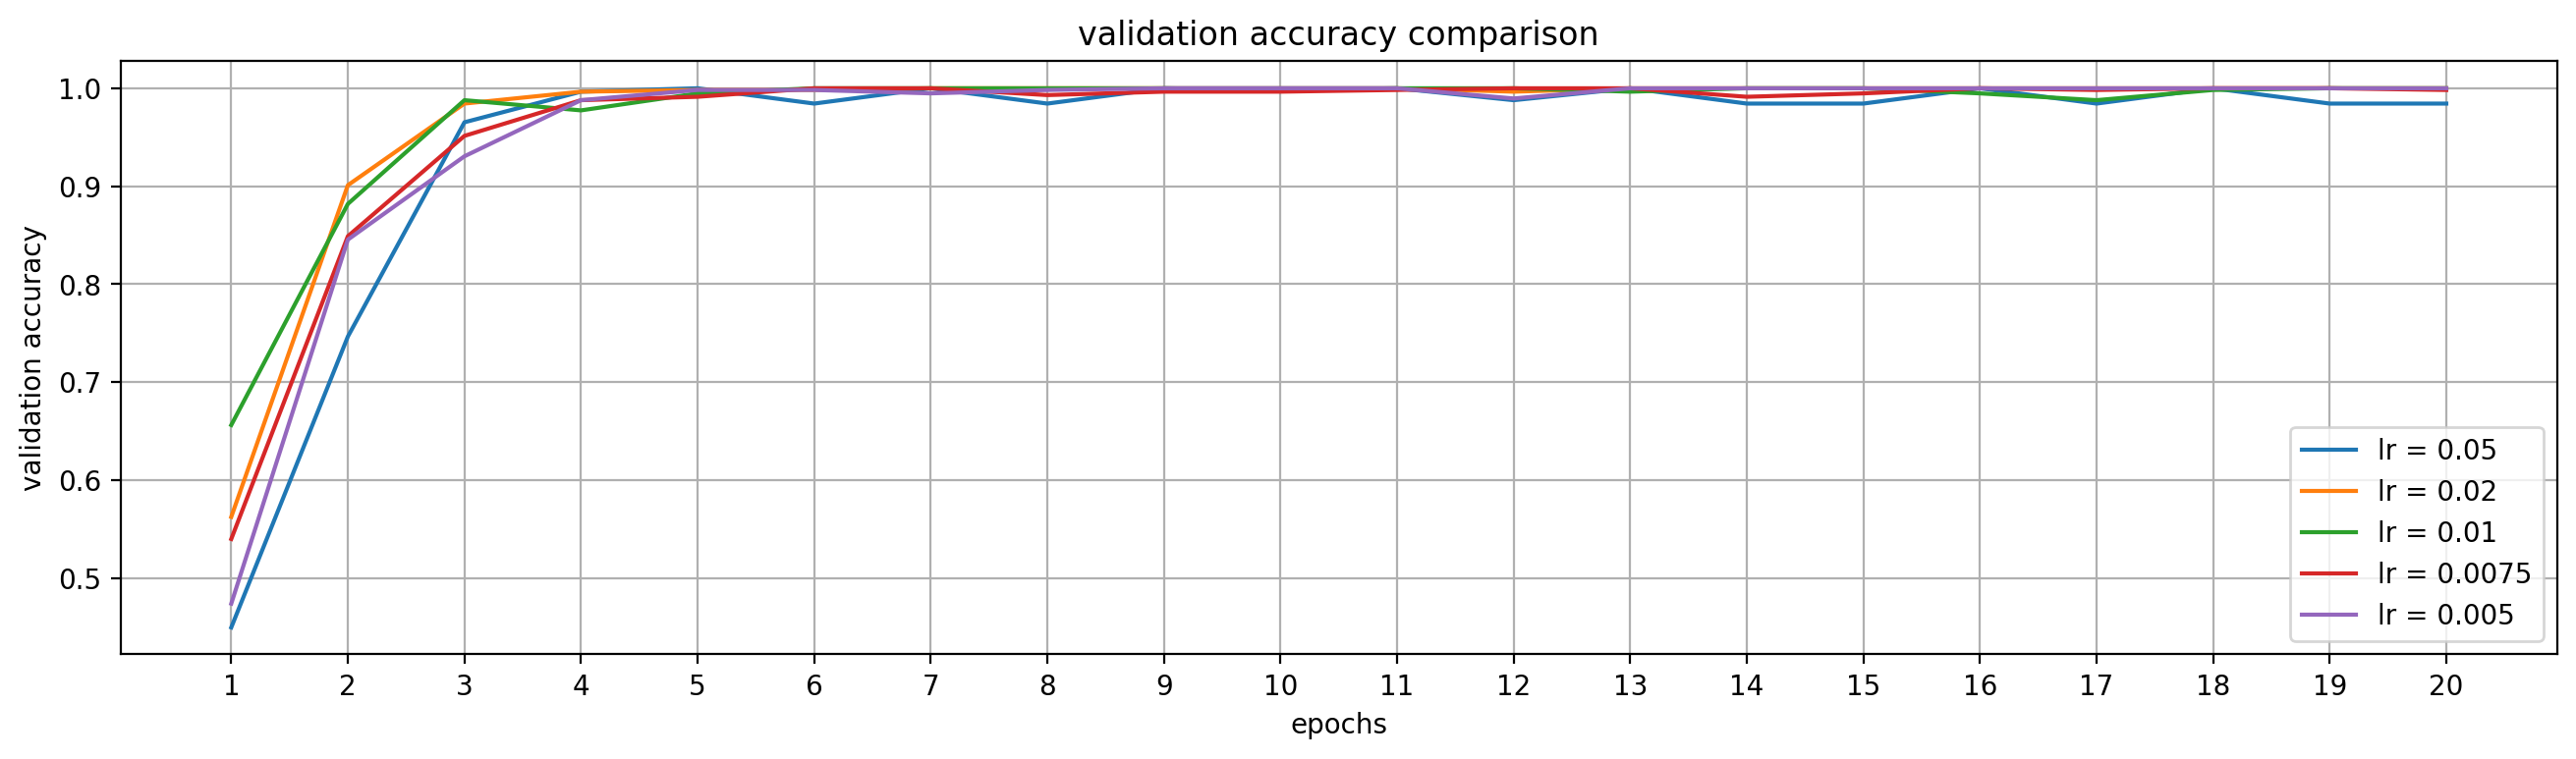

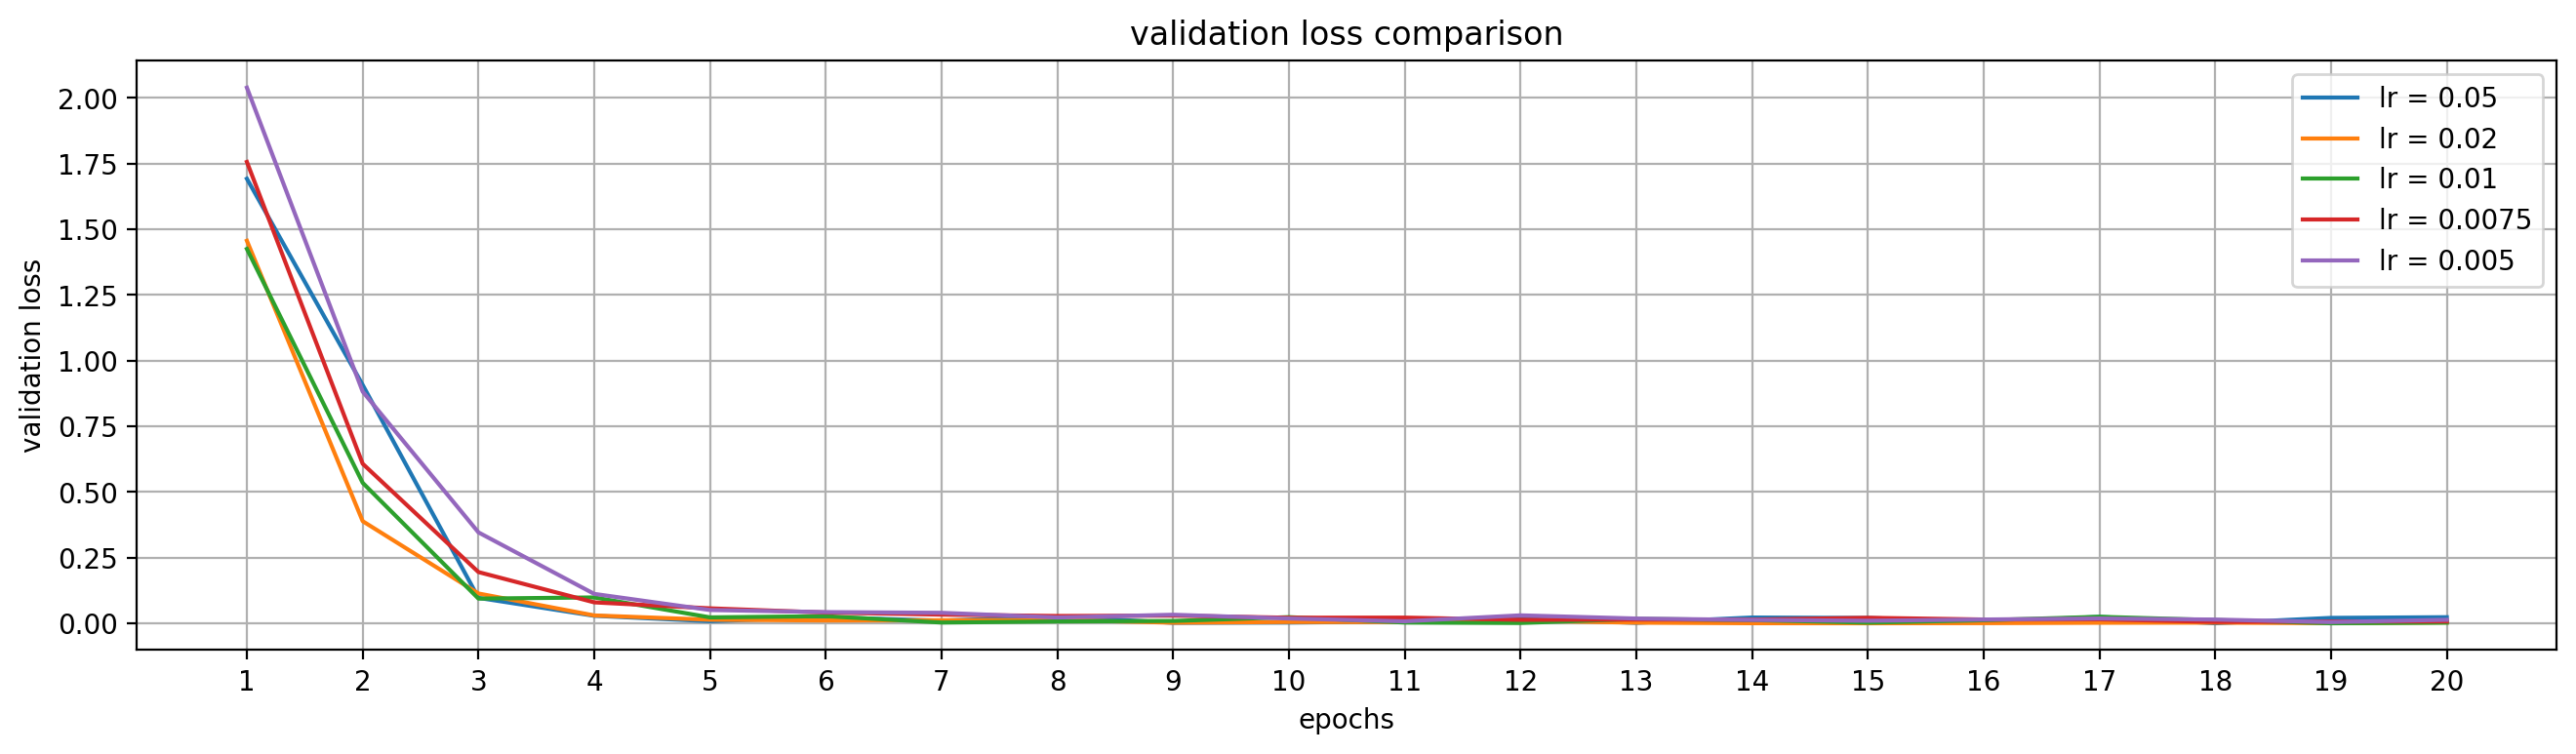

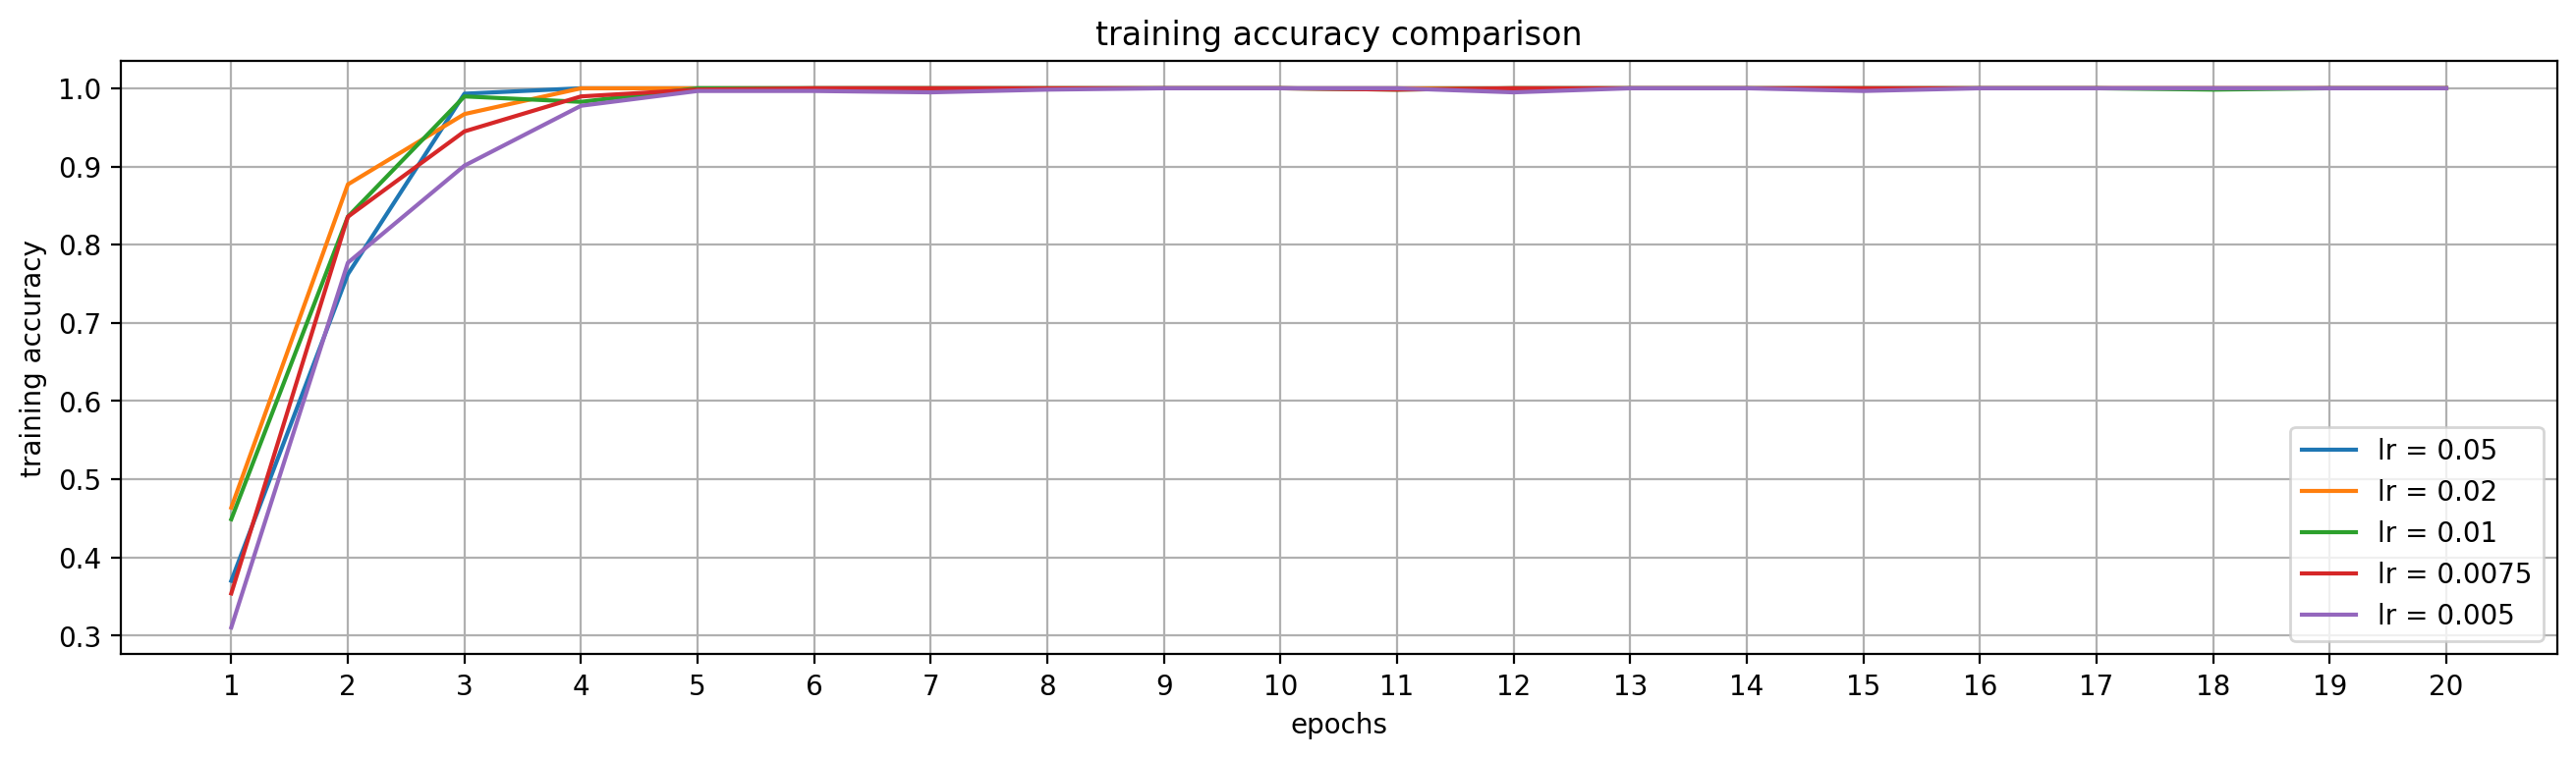

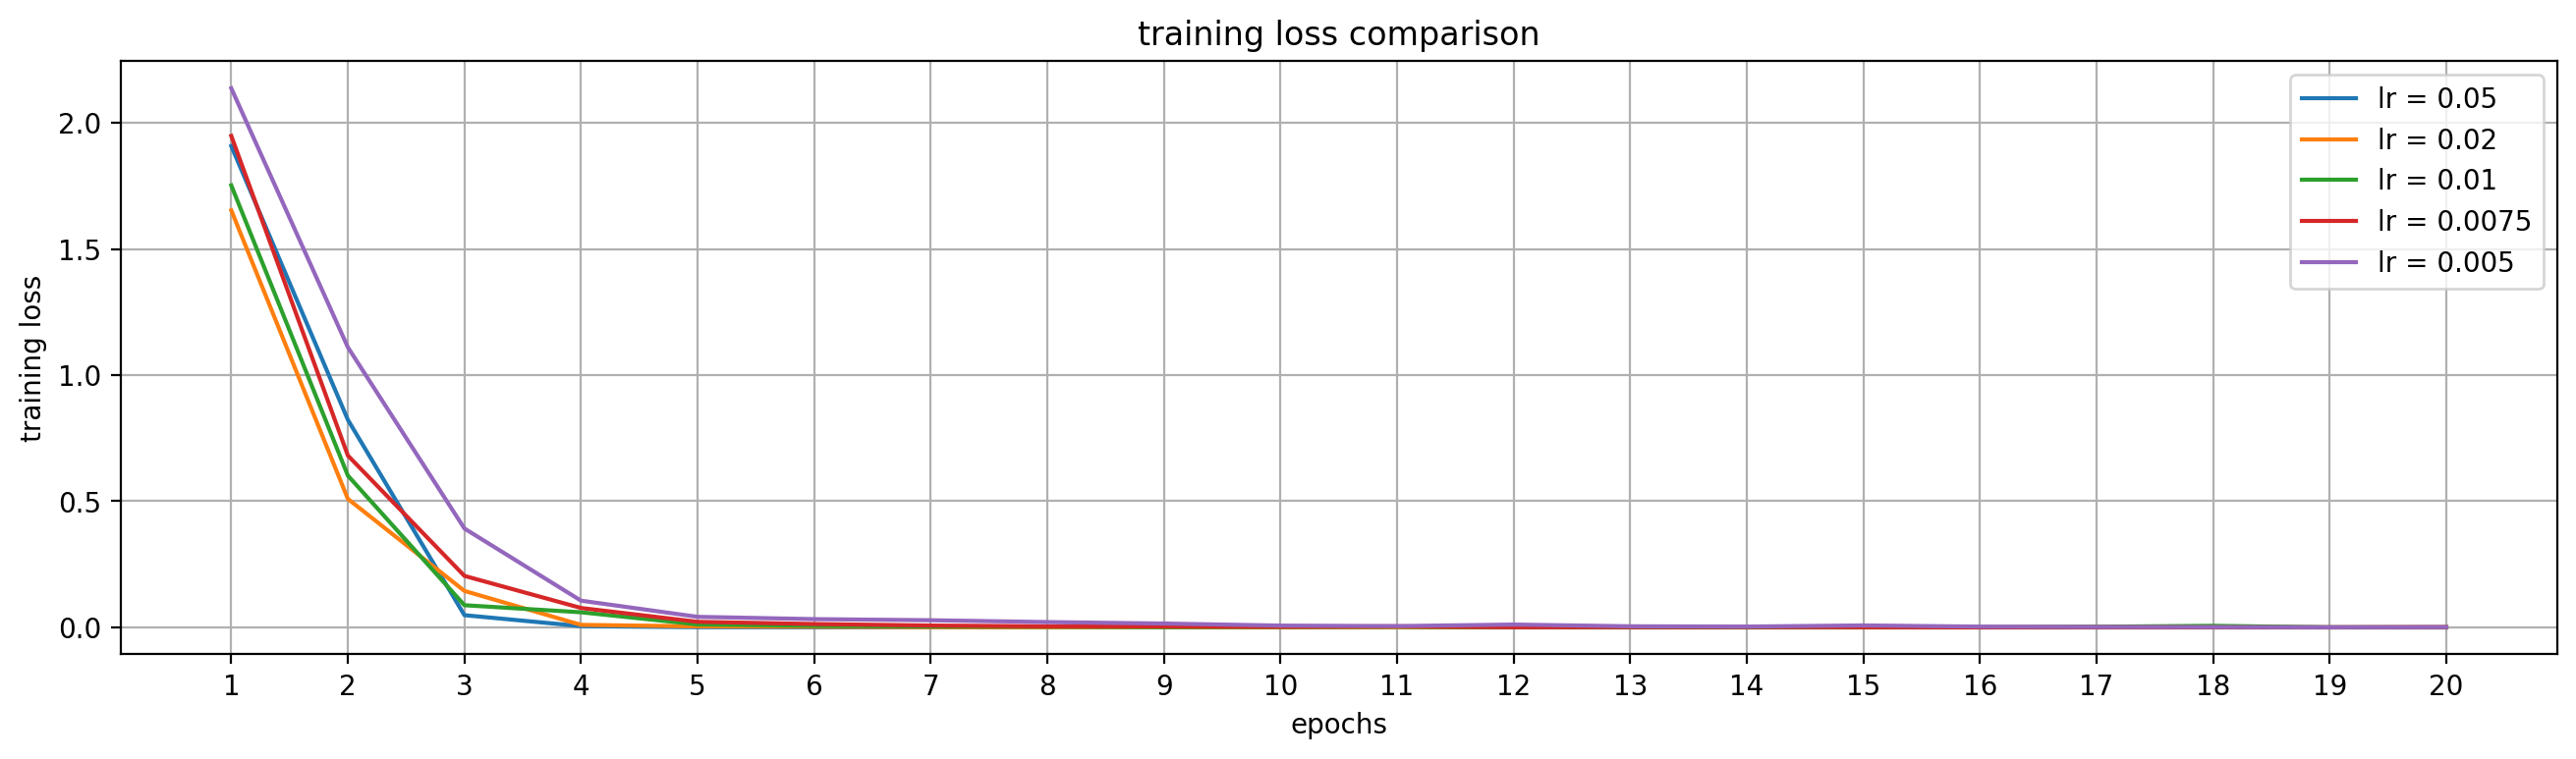

In [23]:
display_results_compare(results_ft2, lrs_to_str(lrs2))

In [24]:
test_results = get_test_results_sorted_by_vl(['finetuning phase 2'], data_loader, device)
print(tabulate(test_results, headers=['#','lr', 'epoch', "val loss", 'val acc',"test loss", "test acc"]))

49/100


  0%|          | 0/49 [00:00<?, ?it/s]

  #      lr    epoch     val loss    val acc    test loss    test acc
---  ------  -------  -----------  ---------  -----------  ----------
  0  0.01         19  0.000616576          1    0.0242449    0.994792
  1  0.02         15  0.000679798          1    0.042864     0.994792
  2  0.05         18  0.000686395          1    0.0244237    0.994792
  3  0.02         14  0.000864708          1    0.0413053    0.994792
  4  0.02         19  0.000992225          1    0.0400626    0.994792
  5  0.02         16  0.00121331           1    0.039563     0.994792
  6  0.01         12  0.00174778           1    0.0345876    0.994792
  7  0.05         13  0.00243976           1    0.0245737    0.994792
  8  0.05          9  0.00252232           1    0.0283894    0.994792
  9  0.02         17  0.00272271           1    0.0320414    0.994792
 10  0.02          9  0.00290356           1    0.0413633    0.994792
 11  0.01         20  0.00299859           1    0.0288097    0.994792
 12  0.01         15

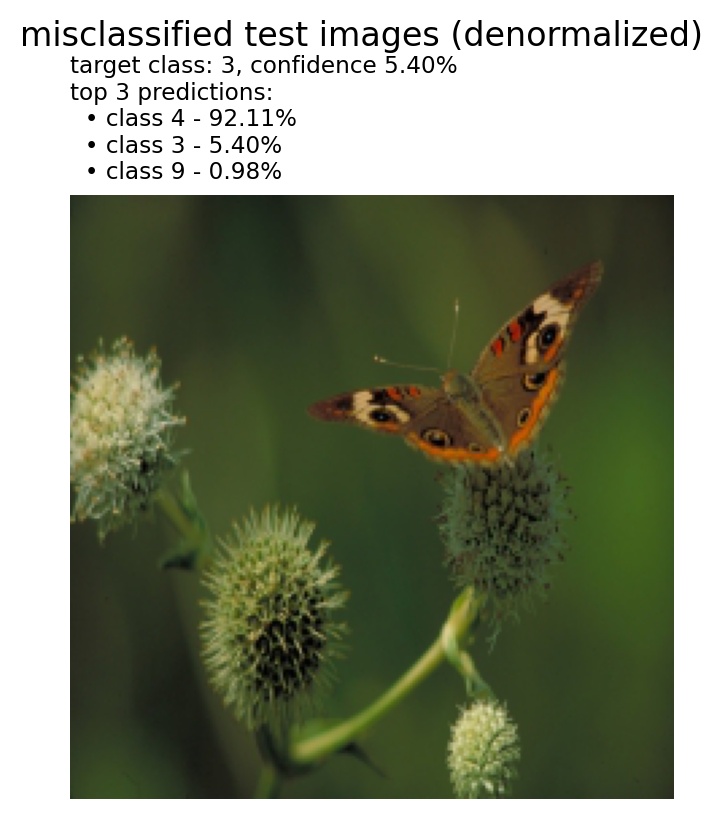

In [25]:
model_subdir = filter_subdirs([f'lr={test_results[0][1]}', 'finetuning phase 2'])
assert len(model_subdir) == 1
model_state_file = model_subdir[0] + f'/models/VGG_{test_results[0][2]}.pt'

model = get_vgg('vgg11').to(device)
cnn_workflow.load_state_to_network(device,model_state_file, model)
show_misclassified(model, device, data_loader.test_loader, test_mean, test_std)

# Part 4